In [58]:
import pandas as pd
import torch
import torch.optim 
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import log, log10
from torch.utils.data import Dataset, DataLoader
import data_processing as dp
import pickle
from privacy_policies_dataset import PrivacyPoliciesDataset
from os.path import isfile, join
from os import listdir
import numpy as np

In [2]:
dictionary = dp.get_tokens("raw_data", read = True)

Loading from file dictionary.pkl


In [3]:
word2vector, word2idx_glove = dp.get_glove_dicts("glove.6B", 50, read = True)

Loading from files word2vector.pkl and word2idx.pkl


In [4]:
weights_matrix, word2idx = dp.get_weight_matrix(dictionary, word2vector, 50, read = True)

Loading from file weights_matrix.pkl


In [5]:
labels_file = open("labels.pkl","rb")

labels = pickle.load(labels_file)

labels_file.close()

In [6]:
dp.aggregate_data(read = True)

Files are already in agg_data/


In [7]:
sentence_matrices_train, labels_matrices_train = dp.process_dataset("train", labels, word2idx, read = True)

Loading from processed_data/


In [8]:
sentence_matrices_test, labels_matrices_test = dp.process_dataset("test", labels, word2idx, read = True)

Loading from processed_data/


In [15]:
train_dataset = PrivacyPoliciesDataset("train" ,"raw_data", word2idx, labels, read = False)

train_dataset.resize_segments()

train_dataset.expand_dimensions()

train_dataset.group_samples()

Processing dataset ...
Resizing segments (filling with zeros). Target size: 425
Grouping samples into one Tensor


In [17]:
train_dataset.segments_list.size()

torch.Size([2026, 1, 425])

In [18]:
train_dataset.labels_list.size()

torch.Size([2026, 10])

In [16]:
test_dataset = PrivacyPoliciesDataset("test" ,"raw_data", word2idx, labels, read = False)

test_dataset.resize_segments()

test_dataset.expand_dimensions()

test_dataset.group_samples()

Processing dataset ...
Resizing segments (filling with zeros). Target size: 387
Grouping samples into one Tensor


In [19]:
test_dataset.segments_list.size()

torch.Size([1700, 1, 387])

In [20]:
test_dataset.labels_list.size()

torch.Size([1700, 10])

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=100)

In [51]:
myemb = nn.Embedding.from_pretrained(torch.tensor(weights_matrix))

myemb.weight.requires_grad

False

In [64]:
print("Before embedding layer: " + str(train_dataset.segments_list.shape))

matrix = myemb(train_dataset.segments_list)

print("After embedding layer: " + str(matrix.shape))

Before embedding layer: torch.Size([2026, 1, 425])
After embedding layer: torch.Size([2026, 1, 425, 50])


In [53]:
class CNN(nn.Module):
    
    def __init__(self, weights_matrix, Co, C, Ks):
        
        super(CNN, self).__init__()
        
        num_embeddings, embeddings_dim = weights_matrix.shape
        
        self.Co = Co
        
        self.C = C
        
        self.Ks = Ks
        
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(weights_matrix).float())       
                       
        self.convolutions = nn.ModuleList([nn.Conv2d(1,self.Co,(k, embeddings_dim)) for k in Ks])
            
        self.relu = nn.ReLU()
            
        #self.max_pool = torch.max
        
        self.linear = nn.Linear(self.Co * len(self.Ks), self.C)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        
        x = self.embedding(x)
        
        x = [self.relu(conv(x)).squeeze(3) for conv in self.convolutions]
        
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        
        x = torch.cat(x,1)
        
        x = self.linear(x)
        
        x = self.sigmoid(x)
        
        return x        

In [141]:
model = CNN(weights_matrix, 10, 10, [3,5,7])

In [146]:
input = train_dataset.segments_list

target = train_dataset.labels_list.float()

optimizer = torch.optim.SGD(model.parameters(), lr= 0.001)

criterion = nn.BCELoss()

losses = []

epochs = []

for epoch in range(20):
    
    for i_batch, sample_batched in enumerate(train_dataloader):

        input = sample_batched[0]
        
        target = sample_batched[1].float()
        
        model.zero_grad()

        output = model(input)

        loss = criterion(output, target)

        loss.backward()

        optimizer.step()
            
    losses.append(loss.item())
    
    epochs.append(epoch)

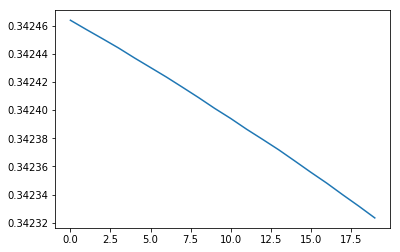

In [147]:
plt.plot(epochs, losses)
plt.show()

In [174]:
threshold = 0.3

y = test_dataset.labels_list

y_hat = model(test_dataset.segments_list)

In [217]:
def compute_accuracy(Y, Y_hat, test = 'ALO', **kwargs):

    def at_least_one(y, y_hat, threshold = 0.2):
        
        y_hat = y_hat > threshold
    
        return any([y_i.item() and y_hat_i.item() for y_i, y_hat_i in zip(y, y_hat)])
    
    def most_probable_label(y, y_hat):

        i_ = [i for i, a in enumerate(y) if a == max(y)]

        [j_] = [j for j, b in enumerate(y_hat) if b == max(y_hat)]
        
        return j_ in i_
    
    num_samples = float(Y.shape[0])
    
    iterations = 0
    
    if test == 'ALO':
        
        print("at least one label label accuracy")
        
        parameters = dict(kwargs)
        
        try:
            
            positives = sum([at_least_one(y, y_hat, parameters['threshold']) for y, y_hat in zip(Y, Y_hat)])
            
        except:
            
            positives = sum([at_least_one(y, y_hat) for y, y_hat in zip(Y, Y_hat)])      
        
    elif test == 'MPL':
                
        print("most probable label accuracy")
        
        positives = sum([most_probable_label(y, y_hat) for y, y_hat in zip(Y, Y_hat)])
        
    else:
        
        print("not a valid test name ...")
        
        positives = 0
    
    return positives / num_samples

compute_accuracy(y, y_hat, 'ALO', threshold = 0.3)

at least one label label accuracy


0.34647058823529414

In [ ]:
torch.save(model, "second_model.model")

### Things to take into consideration

1. It seems that with teh GloVe pretrained embeddings there are 1000 words that are missing and are initialized as random vectors.
2. Here we can see a very strange behaviour. We are expecting to have all 0s except for the last entry in which we are expecting Ln(0.9) and it is not even close to it. It seems they are not computing the BCE exactly as we think.